In [12]:
%load_ext autoreload
%autoreload 2
import dpp
import matplotlib.pyplot as plt
import numpy as np
import torch
from copy import deepcopy
torch.set_default_tensor_type(torch.cuda.FloatTensor)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dpp.data.list_datasets()

['lastfm',
 'stack_overflow',
 'synth/hawkes1',
 'synth/hawkes2',
 'synth/nonstationary_poisson',
 'synth/nonstationary_renewal',
 'synth/self_correcting',
 'synth/stationary_poisson',
 'synth/stationary_renewal']

In [3]:
# Config
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
dataset_name = 'synth/hawkes1'  # run dpp.data.list_datasets() to see the list of available datasets

# Model config
context_size = 64                 # Size of the RNN hidden vector
mark_embedding_size = 32          # Size of the mark embedding (used as RNN input)
num_mix_components = 64           # Number of components for a mixture model
rnn_type = "GRU"                  # What RNN to use as an encoder {"RNN", "GRU", "LSTM"}

# Training config
batch_size = 64        # Number of sequences in a batch
regularization = 1e-5  # L2 regularization parameter
learning_rate = 1e-3   # Learning rate for Adam optimizer
max_epochs = 1000      # For how many epochs to train
display_step = 5       # Display training statistics after every display_step
patience = 50          # After how many consecutive epochs without improvement of val loss to stop training

In [4]:
# Load the data
dataset = dpp.data.load_dataset(dataset_name)
d_train, d_val, d_test = dataset.train_val_test_split(seed=seed)

dl_train = d_train.get_dataloader(batch_size=batch_size, shuffle=True)
dl_val = d_val.get_dataloader(batch_size=batch_size, shuffle=False)
dl_test = d_test.get_dataloader(batch_size=batch_size, shuffle=False)

In [5]:
# Define the model
print('Building model...')
mean_log_inter_time, std_log_inter_time = d_train.get_inter_time_statistics()

model = dpp.models.LogNormMix(
    num_marks=d_train.num_marks,
    mean_log_inter_time=mean_log_inter_time,
    std_log_inter_time=std_log_inter_time,
    context_size=context_size,
    mark_embedding_size=mark_embedding_size,
    rnn_type=rnn_type,
    num_mix_components=num_mix_components,
)
opt = torch.optim.Adam(model.parameters(), weight_decay=regularization, lr=learning_rate)

Building model...


In [6]:
def aggregate_loss_over_dataloader(dl):
    total_loss = 0.0
    total_count = 0
    with torch.no_grad():
        for batch in dl:
            total_loss += -model.log_prob(batch).sum().item()
            total_count += batch.size
    return total_loss / total_count

In [7]:
# Traning
print('Starting training...')

impatient = 0
best_loss = np.inf
best_model = deepcopy(model.state_dict())
training_val_losses = []

for epoch in range(max_epochs):
    model.train()
    for batch in dl_train:
        opt.zero_grad()
        loss = -model.log_prob(batch).mean()
        loss.backward()
        opt.step()

    model.eval()
    with torch.no_grad():
        loss_val = aggregate_loss_over_dataloader(dl_val)
        training_val_losses.append(loss_val)

    if (best_loss - loss_val) < 1e-4:
        impatient += 1
        if loss_val < best_loss:
            best_loss = loss_val
            best_model = deepcopy(model.state_dict())
    else:
        best_loss = loss_val
        best_model = deepcopy(model.state_dict())
        impatient = 0

    if impatient >= patience:
        print(f'Breaking due to early stopping at epoch {epoch}')
        break

    if epoch % display_step == 0:
        print(f"Epoch {epoch:4d}: loss_train_last_batch = {loss.item():.1f}, loss_val = {loss_val:.1f}")

Starting training...
Epoch    0: loss_train_last_batch = 68.7, loss_val = 61.5
Epoch    5: loss_train_last_batch = 49.6, loss_val = 52.4
Epoch   10: loss_train_last_batch = 50.4, loss_val = 51.4
Epoch   15: loss_train_last_batch = 56.8, loss_val = 50.8
Epoch   20: loss_train_last_batch = 49.4, loss_val = 50.4
Epoch   25: loss_train_last_batch = 54.0, loss_val = 49.9
Epoch   30: loss_train_last_batch = 54.8, loss_val = 49.7
Epoch   35: loss_train_last_batch = 56.2, loss_val = 49.6
Epoch   40: loss_train_last_batch = 50.0, loss_val = 49.5
Epoch   45: loss_train_last_batch = 48.2, loss_val = 49.6
Epoch   50: loss_train_last_batch = 37.0, loss_val = 49.6
Epoch   55: loss_train_last_batch = 57.6, loss_val = 49.5
Epoch   60: loss_train_last_batch = 58.9, loss_val = 49.5
Epoch   65: loss_train_last_batch = 52.6, loss_val = 49.5
Epoch   70: loss_train_last_batch = 45.8, loss_val = 49.5
Epoch   75: loss_train_last_batch = 55.3, loss_val = 49.5
Epoch   80: loss_train_last_batch = 28.6, loss_val 

In [8]:
# Evaluation
model.load_state_dict(best_model)
model.eval()

# All training & testing sequences stacked into a single batch
with torch.no_grad():
    final_loss_train = aggregate_loss_over_dataloader(dl_train)
    final_loss_val = aggregate_loss_over_dataloader(dl_val)
    final_loss_test = aggregate_loss_over_dataloader(dl_test)

In [9]:
print(f'Negative log-likelihood:\n'
      f' - Train: {final_loss_train:.1f}\n'
      f' - Val:   {final_loss_val:.1f}\n'
      f' - Test:  {final_loss_test:.1f}')

Negative log-likelihood:
 - Train: 48.6
 - Val:   49.5
 - Test:  43.7


Compare the distribution of sequence lengths for real and simulated data

In [10]:
sampled_batch = model.sample(t_max=100, batch_size=1000)

In [11]:
real_batch = dpp.data.Batch.from_list([s for s in dataset])

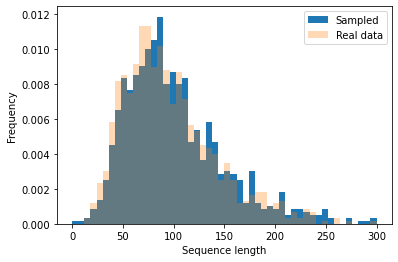

In [16]:
plt.hist(sampled_batch.mask.sum(-1).cpu().numpy(), 50, label="Sampled", density=True, range=(0, 300));
plt.hist(real_batch.mask.sum(-1).cpu().numpy(), 50, alpha=0.3, label="Real data", density=True, range=(0, 300));
plt.xlabel("Sequence length")
plt.ylabel("Frequency")
plt.legend()